In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image

In [2]:
# Global Variables
img_height, img_width = 224, 224
dataset_path = 'test_dataset/1'
bird_path = os.path.join(dataset_path, '1')
nonbird_path = os.path.join(dataset_path, '0')

In [3]:
bird_species_name = ['AMERICAN_GOLDFINCH', 'AMERICAN_ROBIN', 'BLACK-CAPPED_CHICKADEE', 'BLUE_JAY', 'COMMON_STARLING', 
                     'CRESTED_NUTHATCH', 'CROW', 'DOWNY_WOODPECKER', 'HOUSE_FINCH', 'HOUSE_SPARROW', 
                     'MOURNING_DOVE', 'NORTHERN_CARDINAL', 'RED_HEADED_WOODPECKER', 'TIT_MOUSE',
                     'UNKNOWN']

In [4]:
# Preprocessing image Pixels with Z-score normalization
def process(image):
    image = tf.cast(image, tf.float32) / 255.0  # Convert to float and scale to [0, 1]
    mean = tf.reduce_mean(image, axis=(0, 1), keepdims=True)
    std = tf.math.reduce_std(image, axis=(0, 1), keepdims=True)
    image = (image - mean) / (std + 1e-8)  # Z-score normalization, added small epsilon to prevent division by zero
    return image

In [5]:
# Data Generator with z-score normalization
datagen = ImageDataGenerator(
    preprocessing_function=process,
    validation_split=0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [6]:
# Train set generator with shuffle enabled
Train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=256,
    class_mode='categorical',
    subset='training',
    shuffle=True,  # Enable shuffling
    seed=27
)

Found 1935 images belonging to 15 classes.


In [7]:
# Validation set generator with increased shuffle buffer size
Valid_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=160,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=27
)

Found 479 images belonging to 15 classes.


In [8]:
# Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [9]:
# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[:-100]:
    layer.trainable = False

In [10]:
# Create Custom Model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # Increased units
model.add(Dropout(0.8))  # Increased dropout rate
model.add(Dense(15, activation='softmax', kernel_regularizer=regularizers.l2(0.001)))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,168,384 (8.27 MB)

 Non-trainable params: 89,600 (350.00 KB)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 

In [12]:
# Compile the Model with reduced learning rate
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# Train the Model with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model.fit(
    Train_gen,
    epochs=75,  # Increase epochs to allow early stopping to work
    validation_data=Valid_gen,
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/75


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 204s 17s/step - accuracy: 0.2653 - loss: 5.3086 - val_accuracy: 0.4927 - val_loss: 2.2564
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 154s 13s/step - accuracy: 0.3108 - loss: 2.6972 - val_accuracy: 0.5010 - val_loss: 2.0896
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 164s 15s/step - accuracy: 0.3986 - loss: 2.4737 - val_accuracy: 0.5449 - val_loss: 1.9118
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 129s 11s/step - accuracy: 0.4520 - loss: 2.2676 - val_accuracy: 0.5846 - val_loss: 1.7025
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 128s 13s/step - accuracy: 0.4840 - loss: 2.0655 - val_accuracy: 0.6013 - val_loss: 1.7412
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 143s 14s/step - accuracy: 0.5242 - loss: 2.0063 - val_accuracy: 0.6305 - val_loss: 1.6158
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 123s 11s/step - accuracy: 0.5544 - loss: 1.8517 - val_accuracy: 0.6075 - val_loss: 1.7242
Epoch 8/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 126s 11s/step - accuracy: 0.5883 - loss: 1.7570 - val_accuracy: 0.6910 - val_loss: 1.4643
Epo

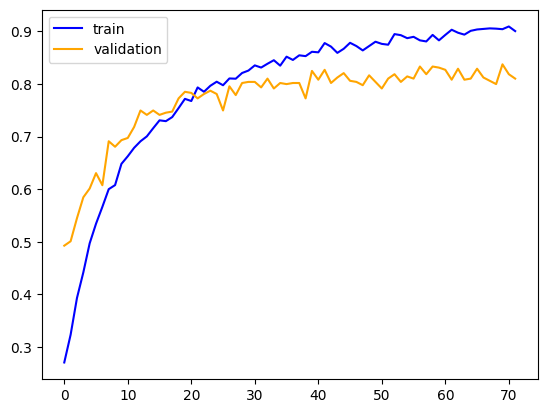

In [14]:
# Plot training history
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [15]:
# Predict on a single image
image_path = 'test_dataset/1/NORTHERN_CARDINAL/001.jpg'
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_species_name = bird_species_name[predicted_class_index]
print("Predicted Bird Species: ", predicted_species_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Bird Species:  NORTHERN_CARDINAL


In [18]:
from tensorflow.python.saved_model.save import save
model.save('multiclass_classifier.h5')

ValueError: Unable to create dataset (name already exists)